In [52]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import tensorflow as tf
import official.nlp.modeling.layers as nlp_layers

tf.keras.utils.set_random_seed(12)
tf.config.experimental.enable_op_determinism()

In [2]:
# DataFrame: X, y 
def reduced_data(X, y, size = 8000):
    df = pd.concat([X_train, y_train], axis = 1)
    df = df.sample(n = size, random_state=1)
    return df 


In [53]:
seed = 34

# df = df.sample(n= 6000, random_state=1)
X_train = pd.read_csv('Diabetes-Data-Shift/X_train.csv').sample(2000, random_state=1)
y_train = pd.read_csv('Diabetes-Data-Shift/y_train.csv').sample(2000, random_state=1)


# train: (872306, 142)  val: (96923, 142)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = seed)

# (121154, 142)
X_test = pd.read_csv('Diabetes-Data-Shift/X_id_test.csv').sample(200, random_state=1)
y_test = pd.read_csv('Diabetes-Data-Shift/y_id_test.csv').sample(200, random_state=1)


# (209375, 142)
X_shift = pd.read_csv('Diabetes-Data-Shift/X_ood_test.csv').sample(200, random_state=1)
y_shift = pd.read_csv('Diabetes-Data-Shift/y_ood_test.csv').sample(200, random_state=1)

# Scale all data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_shift =  scaler.transform(X_shift)


In [96]:
# class Linear(keras.layers.Layer):
#     def __init__(self, units=32, input_dim=32):
#         super().__init__()
#         self.w = self.add_weight(
#             shape=(input_dim, units),
#             initializer="random_normal",
#             trainable=True,
#         )
#         self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

#     def call(self, inputs):
#         return ops.matmul(inputs, self.w) + self.b

# x = ops.ones((2, 2))
# linear_layer = Linear(4, 2)
# y = linear_layer(x)
# print(y)

# [[ 0.085416   -0.06821361 -0.00741937 -0.03429271]
#  [ 0.085416   -0.06821361 -0.00741937 -0.03429271]]

# assert linear_layer.weights == [linear_layer.w, linear_layer.b]

In [ ]:
# Best practice: deferring weight creation until the shape of the inputs is known

# class Linear(keras.layers.Layer):
#     def __init__(self, units=32):
#         super().__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.w = self.add_weight(
#             shape=(input_shape[-1], self.units),
#             initializer="random_normal",
#             trainable=True,
#         )
#         self.b = self.add_weight(
#             shape=(self.units,), initializer="random_normal", trainable=True
#         )

#     def call(self, inputs):
#         return ops.matmul(inputs, self.w) + self.b

# # At instantiation, we don't know on what inputs this is going to get called
# linear_layer = Linear(32)

# # The layer's weights are created dynamically the first time the layer is called
# y = linear_layer(x)

In [54]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [ self.make_dense_layer() for _ in range(num_layers) ]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)
 
# This method should not be called directly. 
# It is only meant to be overridden when subclassing tf.keras.Model. 
# To call a model on an input, always use the __call__() method, 
# i.e. model(inputs), which relies on the underlying call() method.
 
  def call(self, inputs, return_hidden = False):  # , return_hidden = False
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)
    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid
    if return_hidden:
      return hidden, self.classifier(hidden)
    else:
      return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [55]:
resnet_config = dict(num_classes = 2, num_layers= 3, num_hidden= 256) # 512

resnet_model = DeepResNet(**resnet_config)

# Weights are initialized 
resnet_model.build( (None, 142) )
resnet_model.summary()

Model: "deep_res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            multiple                  36608     
                                                                 
 dense_19 (Dense)            multiple                  65792     
                                                                 
 dense_20 (Dense)            multiple                  65792     
                                                                 
 dense_21 (Dense)            multiple                  65792     
                                                                 
 dense_22 (Dense)            multiple                  514       
                                                                 
Total params: 234498 (916.01 KB)
Trainable params: 197890 (773.01 KB)
Non-trainable params: 36608 (143.00 KB)
_________________________________________________________________


In [56]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2,
                                            restore_best_weights = True)

In [57]:
fit_config = dict(batch_size = 256, epochs= 10,
            validation_data = (X_val, y_val), callbacks=[callback] )

resnet_model.compile(**train_config)

history = resnet_model.fit(X_train, y_train, **fit_config)

Epoch 1/10
8/8 [==============================] - 0s 16ms/step - loss: 0.7132 - sparse_categorical_accuracy: 0.5911 - val_loss: 0.3397 - val_sparse_categorical_accuracy: 0.8850
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3756 - sparse_categorical_accuracy: 0.8739 - val_loss: 0.3115 - val_sparse_categorical_accuracy: 0.9050
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.8833 - val_loss: 0.3106 - val_sparse_categorical_accuracy: 0.9050
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.2848 - val_sparse_categorical_accuracy: 0.9050
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3368 - sparse_categorical_accuracy: 0.8794 - val_loss: 0.2789 - val_sparse_categorical_accuracy: 0.8950
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.8767 - va

<Axes: >

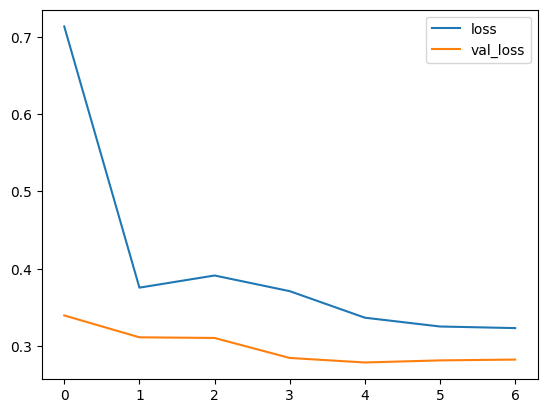

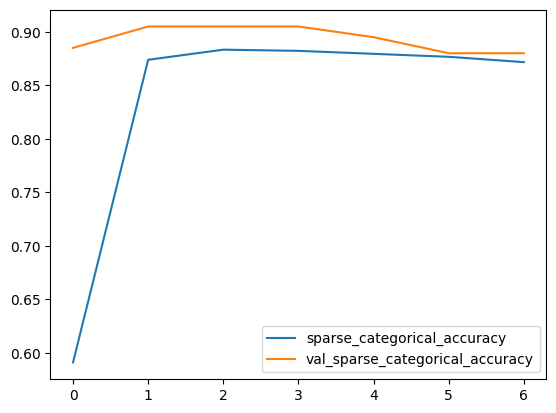

In [58]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()

history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()
# history_df.loc[:, ['output_2_sparse_categorical_accuracy','val_output_2_sparse_categorical_accuracy']].plot()
# history_df.loc[:, ['output_1_sparse_categorical_accuracy','val_output_1_sparse_categorical_accuracy']].plot()
# history_df.loc[:, ['output_2_sparse_categorical_accuracy','val_output_2_sparse_categorical_accuracy']].plot()

In [103]:
# Return the training hidden space in Standard NN 
hidden_train_NN, NN_train_logits = resnet_model(X_train, return_hidden = True )
hidden_test_NN, NN_train_logits = resnet_model(X_test, return_hidden = True )
hidden_shift_NN, NN_shift_logits = resnet_model(X_shift, return_hidden = True)

In [ ]:
# Compute Stanrdard NN accuray 

In [60]:
def NN_accuracy(X, y):
    # hidden, logits = resnet_model.predict(X)
    logits = resnet_model.predict(X)
    predictions = tf.nn.softmax(logits, axis=-1)[:, 0]
    probs = np.where( predictions > 0.5 , 0, 1)
    accuracy = accuracy_score(y, probs)
    print(f'accuracy -- {accuracy}')
    return accuracy

NN_accuracy_test = NN_accuracy(X_test, y_test)
NN_accuracy_shift = NN_accuracy(X_shift, y_shift)

7/7 [==============================] - 0s 526us/step
accuracy -- 0.88
7/7 [==============================] - 0s 476us/step
accuracy -- 0.86


In [34]:
# Save the model
# import keras 
# resnet_model.save('Standard_model',save_format='tf')
# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('Standard_model')

In [35]:
# resnet_model = tf.keras.models.load_model('resnet_model.h5')
# #resnet_model = tf.keras.models.load_model('resnet_model.keras')

In [36]:
# SNGP 

In [61]:
class DeepResNetSNGP(DeepResNet):
  def __init__( self, spec_norm_bound = 0.9, **kwargs ):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  # Override the father class's method
  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier = self.spec_norm_bound)

  # Override the father class's method
  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_kernel_scale = 1.0,
        gp_cov_momentum = -1,
        **self.classifier_kwargs)
  
  def call(self, inputs, training=False, return_covmat = False, return_hidden = False): #, return_hidden=True
    # Gets logits and a covariance matrix from the GP layer.
    
    # super().cal() -- call the parents' call()
    if return_hidden:
      hidden, (logits, covmat) = super().call(inputs, return_hidden) #, return_hidden=True
    else:
      logits, covmat = super().call(inputs) #, return_hidden=True
    
    # Returns only logits during training.
    if not training and return_covmat and return_hidden: # and return_hidden
      return hidden, (logits, covmat)

    return logits

In [62]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs = None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [63]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [64]:
# This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]

In [65]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/10
8/8 [==============================] - 1s 19ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.5555 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.5433 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.5050
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.5428 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5100


<Axes: >

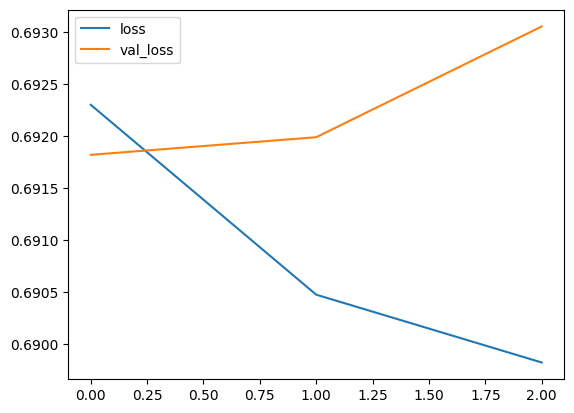

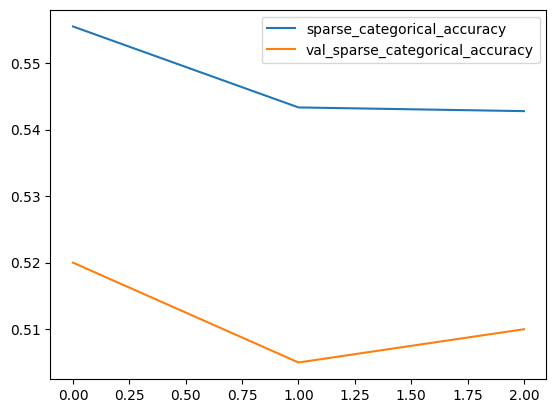

In [66]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

In [43]:
# resnet_model.save('SNGP_model',save_format='tf')
# # Recreate the exact same model purely from the file
# resnet_model = keras.models.load_model('SNGP_model')

In [67]:
def compute_variance(x):
  hidden, (sngp_logits, sngp_covmat) = sngp_model(x, return_covmat=True, return_hidden = True)
  
  sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
  mean_var = np.mean(sngp_variance)
  print(f'Mean variance -- {mean_var}')
  return hidden, sngp_variance

train_hidden_sngp, train_var_sngp = compute_variance(X_train)

test_hidden_sngp, test_var_sngp = compute_variance(X_test)
shift_hidden_sngp, shift_var_sngp = compute_variance(X_shift)
# OOD_hidden_sngp, OOD_var_sngp = compute_variance(OOD_1)

#train_var_sngp = train_var_sngp.numpy().ravel()
test_var_sngp = test_var_sngp.numpy().ravel()
shift_var_sngp = shift_var_sngp.numpy().ravel()
#OOD_var_sngp = OOD_var_sngp.numpy().ravel()

Mean variance -- 0.4224807322025299
Mean variance -- 0.4503229558467865
Mean variance -- 0.4538847804069519


In [71]:
def compute_accuracy(model, X, y):
  hidden, (sngp_logits, sngp_covmat)= model(X, return_covmat=True, return_hidden = True)
  
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
  probs = np.where( sngp_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)
  print(f'SNGP accuracy --{accuracy}')
  return
compute_accuracy(sngp_model, X_test, y_test)
compute_accuracy(sngp_model, X_shift, y_shift)

SNGP accuracy --0.53
SNGP accuracy --0.49


In [46]:
# Compute input distance 

In [72]:
def compute_distane(train_hidden, test_hidden, k = 10):
    distances = tf.norm(tf.expand_dims(test_hidden, axis=1) - tf.expand_dims(train_hidden, axis=0), axis=-1)
    topk_distances, topk_indices = tf.math.top_k(-distances, k=k)  # Use negative distances for smallest k distances
    return - topk_distances

In [73]:
test_distance = compute_distane(X_train, X_test)
shift_distance = compute_distane(X_train, X_shift)
#OOD_distance = compute_distane(X_train, OOD_1)

# Compute mean along axis = 1 (rows)
test_mean_inp = tf.reduce_mean(test_distance, axis=1).numpy()
shift_mean_inp = tf.reduce_mean(shift_distance, axis=1).numpy()
#OOD_mean_inp = tf.reduce_mean(OOD_distance, axis=1).numpy()

In [49]:
# Hidden distance space in SNGP

In [75]:
test_distance_sngp = compute_distane(train_hidden_sngp, test_hidden_sngp)
shift_distance_sngp = compute_distane(train_hidden_sngp, shift_hidden_sngp)
# OOD_distance_sngp = compute_distane(train_hidden_sngp, OOD_hidden_sngp)

# Compute mean along axis 1 (rows)
test_mean_sngp = tf.reduce_mean(test_distance_sngp, axis=1).numpy()
shift_mean_sngp = tf.reduce_mean(shift_distance_sngp, axis=1).numpy()
# OOD_mean_sngp = tf.reduce_mean(OOD_distance_sngp, axis=1).numpy()

In [51]:
# MC Dropout

In [76]:
num_ensemble = 10

In [104]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  hidden, logits = resnet_model(test_examples, return_hidden = True)
  return hidden, logits

In [107]:
# Monte Carlo dropout inference.
def Compute_MC(model, X, y):
  
  hidden = model(X)[0]
  dropout_logit_samples = [ model(X)[1] for _ in range(num_ensemble) ]

  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)

  dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)
  probs = np.where( dropout_probs > 0.5 , 0, 1)
  accuracy = accuracy_score(y, probs)

  #uncertainty = (dropout_probs)*(1-dropout_probs)
  print(f'Accuracy: {accuracy} -- Mean variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_mc, var_mc = Compute_MC(mc_dropout_sampling, X_train, y_train)
test_hidden_mc, test_var_mc = Compute_MC(mc_dropout_sampling, X_test, y_test)
shift_hidden_mc, shift_var_mc = Compute_MC(mc_dropout_sampling, X_shift, y_shift)

Accuracy: 0.8788888888888889 -- Mean variance:3.571957420329171e-15
Accuracy: 0.88 -- Mean variance:3.677058538973906e-15
Accuracy: 0.86 -- Mean variance:3.712585641880593e-15


In [108]:
# OOD
def Compute_MC_OOD(model, X):
  dropout_logit_samples = [model(X) for _ in range(num_ensemble)]
  dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
  vars = np.var(dropout_prob_samples, axis=0)
  print(f'Mean Variance --{np.mean(vars)}')
  print(hidden.shape)
  return vars
#OOD_hidden_mc, OOD_var_mc = Compute_MC_OOD(mc_dropout_sampling, OOD_1)

In [109]:
test_distance_mc = compute_distane(train_hidden_mc, test_hidden_mc)
shift_distance_mc = compute_distane(train_hidden_mc, shift_hidden_mc)
# OOD_distance_mc = compute_distane(train_hidden_mc, OOD_hidden_mc)

# compute mean along axis 1 (rows)
test_mean_mc = tf.reduce_mean(test_distance_mc, axis=1).numpy()
shift_mean_mc = tf.reduce_mean(shift_distance_mc, axis=1).numpy()
# OOD_mean_mc = tf.reduce_mean(OOD_distance_mc, axis=1).numpy()

In [57]:
# plot_hidden_distance_hist(test_mean_mc , shift_mean_mc, OOD_mean_mc, 'Hidden_Dist_Hist_mc.pdf' )
# scatter_var_dist(test_mean_mc, shift_mean_mc, OOD_mean_mc, test_var_mc, shift_var_mc, OOD_var_mc, 'Dist_Var_MC.pdf')
# plot_variance_hist(test_var_mc, shift_var_mc, OOD_var_mc, 'MC_Var.pdf') # np.finfo(float).eps

In [58]:
# Deep ensemble training

In [111]:
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

In [114]:
def Compute_Deep(model_list, X, y):

  hidden = [model(X, return_hidden = True)[0] for model in model_list]

  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X, return_hidden = True)[1] for model in model_list]
  ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
  ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

  vars = np.var(ensemble_prob_samples, axis = 0)
  probs = np.where( ensemble_probs > 0.5 , 0, 1)
  
  accuracy = accuracy_score(y, probs)

  #uncertainty = ensemble_probs * (1 - ensemble_probs)
  #uncertainty = np.mean(uncertainty)
  print(f'accuracy: {accuracy} -- Mean Variance:{np.mean(vars)}')
  return hidden, vars

train_hidden_deep, var = Compute_Deep(resnet_ensemble, X_train, y_train)

test_hidden_deep, test_var_deep = Compute_Deep(resnet_ensemble, X_test, y_test)
shift_hidden_deep, shift_var_deep = Compute_Deep(resnet_ensemble, X_shift, y_shift)

accuracy: 0.8861111111111111 -- Mean Variance:0.0017255173297598958
accuracy: 0.88 -- Mean Variance:0.0019850011449307203
accuracy: 0.87 -- Mean Variance:0.0019915199372917414


In [61]:
def Compute_Deep_OOD(model_list, X):
  hidden = [ model(X)[0] for model in model_list]
  hidden = tf.reduce_mean(hidden, axis = 0)

  ensemble_logit_samples = [model(X)[1] for model in model_list]
  #print(ensemble_logit_samples)
  
  predictions = [tf.nn.softmax(logits)[:,0] for logits in ensemble_logit_samples]
  #print(ensemble_prob_samples)
  vars = np.var(predictions, axis = 0)
  print(f'Mean Variance--{np.mean(vars)}')

  return hidden, vars

OOD_hidden_deep, OOD_var_deep = Compute_Deep_OOD(resnet_ensemble, OOD_1)

Mean Variance--0.14900736510753632


In [115]:
test_distance_deep = compute_distane(train_hidden_deep, test_hidden_deep)
shift_distance_deep = compute_distane(train_hidden_deep, shift_hidden_deep)
#OOD_distance_deep = compute_distane(train_hidden_deep, OOD_hidden_deep)

# compute mean along axis 1 (rows)
test_mean_deep = tf.reduce_mean(test_distance_deep, axis=1).numpy()
shift_mean_deep = tf.reduce_mean(shift_distance_deep, axis=1).numpy()
#OOD_mean_deep = tf.reduce_mean(OOD_distance_deep, axis=1).numpy()

In [63]:
print(OOD_mean_deep.shape)
print(OOD_var_deep.shape)

(559,)
(559,)


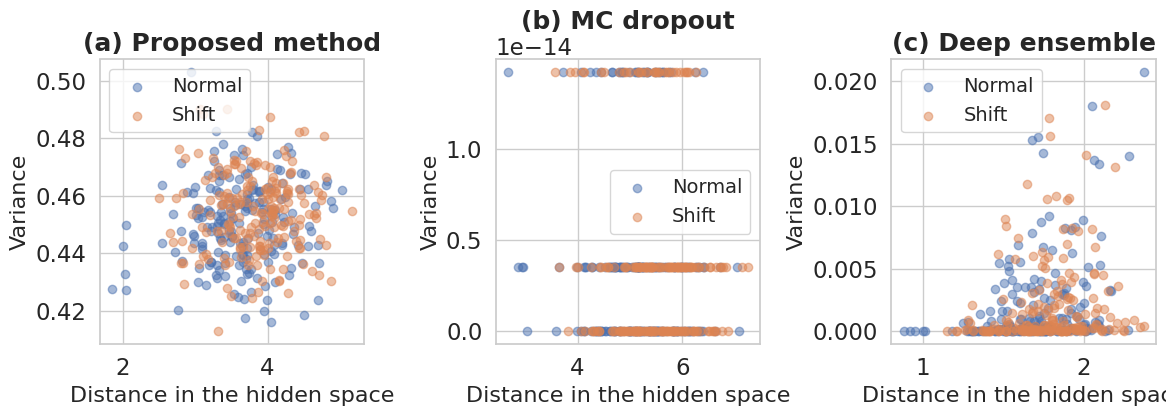

In [118]:
sns.set(style="whitegrid", font_scale = 1.5 )

fig, (ax1, ax2, ax3) = plt.subplots( 1, 3, figsize=(12, 4.5), tight_layout=True ) # 11.69,8.27

ax1.scatter(test_mean_sngp,  test_var_sngp,  alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax1.scatter(shift_mean_sngp, shift_var_sngp, alpha= 0.5, rasterized=True,label = 'Shift')
#ax1.scatter(OOD_mean_sngp,   OOD_var_sngp,   alpha= 0.5, rasterized=True,label = 'OOD')


ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the hidden space', fontsize = 16)
ax1.set_ylabel('Variance', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")


ax2.scatter(test_mean_mc,  test_var_mc,  alpha= 0.5,  rasterized=True, label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax2.scatter(shift_mean_mc, shift_var_mc, alpha= 0.5, rasterized=True, label = 'Shift')
#ax2.scatter(OOD_mean_mc,   OOD_var_mc,   alpha= 0.5, rasterized=True, label = 'OOD')

ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Variance', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")


ax3.scatter(test_mean_deep,  test_var_deep,  alpha= 0.5, rasterized=True,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',  
ax3.scatter(shift_mean_deep, shift_var_deep, alpha= 0.5, rasterized=True,label = 'Shift')
#ax3.scatter(OOD_mean_deep,   OOD_var_deep,   alpha= 0.5, rasterized=True, label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Variance', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")

plt.tight_layout() 
plt.savefig('Dist-Var-comb.pdf')
plt.show()

In [80]:
def cal_correlation(x1, x2):
    correlation_matrix = np.corrcoef(x1, x2)
    correlation_coefficient = correlation_matrix[0, 1]
    return correlation_coefficient

def concat_data(x1, x2, x3):
    return np.concatenate((x1, x2, x3), axis = 0)

sngp_dist = concat_data(test_mean_sngp,shift_mean_sngp,OOD_mean_sngp)
sngp_var =  concat_data(test_var_sngp, shift_var_sngp, OOD_var_sngp)
print(cal_correlation(sngp_dist, sngp_var))

print(cal_correlation(test_mean_sngp,  test_var_sngp))
print(cal_correlation(shift_mean_sngp, shift_var_sngp))
print(cal_correlation(OOD_mean_sngp,   OOD_var_sngp))


mc_dist = concat_data(test_mean_mc, shift_mean_mc, OOD_mean_mc)
mc_var =  concat_data(test_var_mc, shift_var_mc, OOD_var_mc)
print(cal_correlation(mc_dist, mc_var))
print(cal_correlation(test_mean_mc,  test_var_mc))
print(cal_correlation(shift_mean_mc, shift_var_mc))
print(cal_correlation(OOD_mean_mc,   OOD_var_mc))


deep_dist = concat_data(test_mean_deep, shift_mean_deep, OOD_mean_deep)
deep_var =  concat_data(test_var_deep.ravel(), shift_var_deep.ravel(), OOD_var_deep.ravel())
print(cal_correlation(deep_dist, deep_var))
print(cal_correlation(test_mean_deep,  test_var_deep))
print(cal_correlation(shift_mean_deep, shift_var_deep))
print(cal_correlation(OOD_mean_deep,   OOD_var_deep))

NameError: name 'OOD_mean_sngp' is not defined

NameError: name 'OOD_mean_inp' is not defined

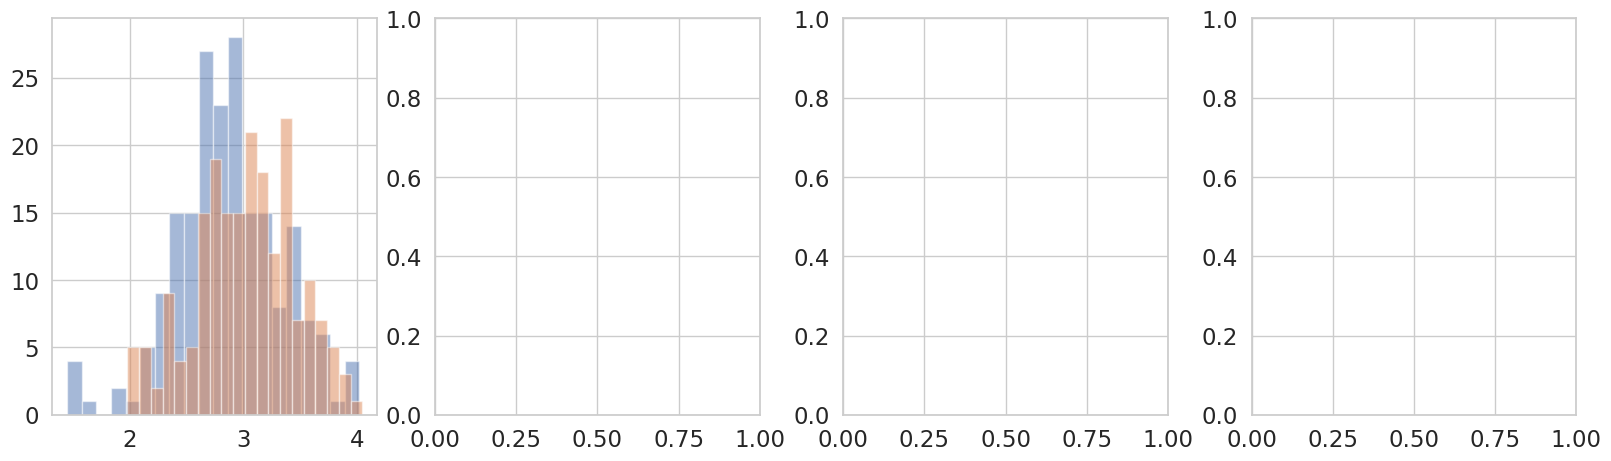

In [81]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4.5), layout='constrained' ) # 11.69,8.27

ax1.hist(test_mean_inp, bins = 20, alpha= 0.5, label = 'Normal') # density=True,
ax1.hist(shift_mean_inp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_mean_inp, alpha= 0.5, label = 'OOD')
ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Distance in the input space', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Histogram of distance', fontweight="bold")


ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.hist(test_mean_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax2.hist(shift_mean_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax2.hist(OOD_mean_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.legend(fontsize=14)
ax2.set_xlabel('Distance in the hidden space', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) Proposed method', fontweight="bold")

ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.hist(test_mean_mc,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax3.hist(shift_mean_mc, bins = 20, alpha= 0.5, label = 'Shift')
ax3.hist(OOD_mean_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.legend(fontsize=14)
ax3.set_xlabel('Distance in the hidden space', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) MC dropout', fontweight="bold")

ax4.set_xscale('log', base=10)
ax4.set_yscale('log', base=10)
ax4.hist(test_mean_deep,  bins = 20, alpha= 0.5,  label = 'Normal') #color = 'blue',color = 'orange',color = 'green',
ax4.hist(shift_mean_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax4.hist(OOD_mean_deep,   bins = 20, alpha= 0.5, label = 'OOD')
ax4.legend(fontsize=14)
ax4.set_xlabel('Distance in the hidden space', fontsize = 16)
ax4.set_ylabel('Frequency', fontsize = 16)
ax4.set_title('(d) Deep ensemble', fontweight="bold")

plt.tight_layout()
plt.savefig('Hidden-Distance-comb.pdf')
plt.show()

NameError: name 'OOD_var_sngp' is not defined

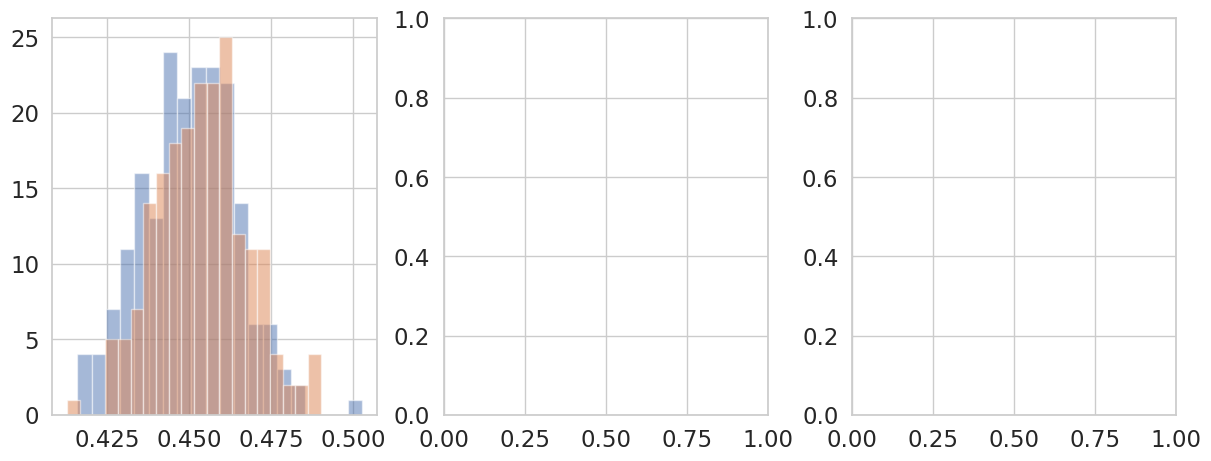

In [82]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5, label = 'Normal') 
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5, label = 'Shift')
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Variance', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
ax1.set_title('(a) Proposed method', fontweight="bold")

ax2.hist(test_var_mc,  bins = 20, alpha= 0.5,  label = 'Normal') 
ax2.hist(shift_var_mc, bins = 20, alpha= 0.5,  label = 'Shift')
ax2.hist(OOD_var_mc,   bins = 20, alpha= 0.5,  label = 'OOD')
ax2.set_xscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.legend(fontsize=14)
ax2.set_xlabel('Variance', fontsize = 16)
ax2.set_ylabel('Frequency', fontsize = 16)
ax2.set_title('(b) MC dropout', fontweight="bold")

ax3.hist(test_var_deep,  bins = 20, alpha= 0.5, label = 'Normal') 
ax3.hist(shift_var_deep, bins = 20, alpha= 0.5,  label = 'Shift')
ax3.hist(OOD_var_deep,   bins = 20, alpha= 0.5,  label = 'OOD')
ax3.set_xscale('log', base=10)
ax3.set_yscale('log', base=10)
ax3.legend(fontsize=14)
ax3.set_xlabel('Variance', fontsize = 16)
ax3.set_ylabel('Frequency', fontsize = 16)
ax3.set_title('(c) Deep ensemble', fontweight="bold")
plt.tight_layout()
plt.savefig('Var-hist-comb.pdf')
plt.show()

0.5028971


NameError: name 'OOD_var_sngp' is not defined

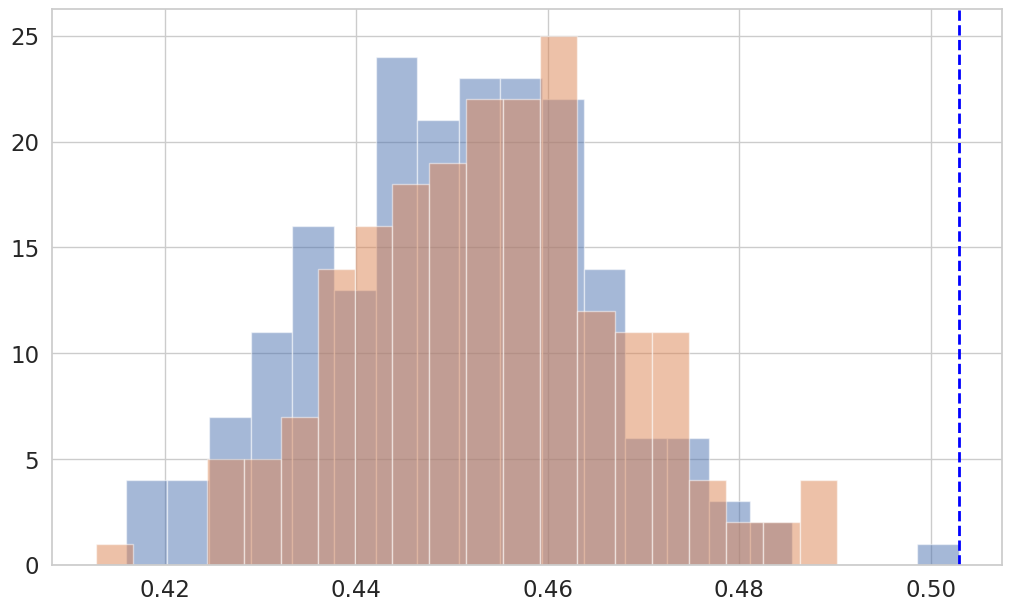

In [83]:
sns.set(style="whitegrid", font_scale = 1.5)
fig, (ax1) = plt.subplots(1,1, figsize=(10, 6), layout='constrained' )

ax1.hist(test_var_sngp,  bins = 20, alpha= 0.5,  label = 'Normal') 
plt.axvline(x= test_var_sngp.max(), color = 'blue', lw = 2, ls = '--' )
print(test_var_sngp.max())
ax1.hist(shift_var_sngp, bins = 20, alpha= 0.5,  label = 'Shift')
plt.axvline(x= OOD_var_sngp.min(), color = 'red', lw = 2, ls = '--')
print(OOD_var_sngp.min())
ax1.hist(OOD_var_sngp,   bins = 20, alpha= 0.5,  label = 'OOD')

ax1.set_xscale('log', base=10)
ax1.set_yscale('log', base=10)
ax1.legend(fontsize=14)
ax1.set_xlabel('Predictive uncertainty', fontsize = 16)
ax1.set_ylabel('Frequency', fontsize = 16)
# ax1.set_title('Proposed method', fontweight="bold")
plt.tight_layout()
plt.savefig('var_risk.pdf')